# 데이터 전처리

In [1]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [3]:
# ✅ 훈련 데이터 전처리 (데이터 증강 포함)
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),                     # 크롭 전 여유 공간 확보
    transforms.CenterCrop(224),                        # 중심부 크롭 (폐 중심)
    transforms.RandomHorizontalFlip(p=0.5),            # 좌우 반전 증강
    transforms.RandomRotation(10),                     # 회전 증강
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 밝기/대비 증강
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],         # ImageNet 평균
                         [0.229, 0.224, 0.225])         # ImageNet 표준편차
])

# ✅ 검증 및 테스트 데이터 전처리 (증강 없이 정규화만)
eval_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ✅ 데이터셋 로딩
train_dataset = datasets.ImageFolder("C:/DL/data/chest_xray/train", transform=train_transform)
val_dataset   = datasets.ImageFolder("C:/DL/data/chest_xray/val", transform=eval_transform)
test_dataset  = datasets.ImageFolder("C:/DL/data/chest_xray/test", transform=eval_transform)

# ✅ 데이터로더 설정
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

# 모델 불러오기

In [6]:
from efficientnet_pytorch import EfficientNet
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# EfficientNet-b0 불러오기
model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Linear(model._fc.in_features, 2)  # 클래스 수: NORMAL vs PNEUMONIA
model = model.to(device)

Loaded pretrained weights for efficientnet-b0


# 학습 루프

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import efficientnet_b0
import time

# 모델, 손실 함수, 옵티마이저 설정
model = efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)  # 클래스 수에 맞게 수정
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scaler = GradScaler()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# EarlyStopping 설정
best_val_loss = float('inf')
patience = 5
trigger_times = 0

# DataLoader 최적화
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=32, num_workers=4, pin_memory=True)

# 학습 시작
num_epochs = 30
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # 검증 단계
    model.eval()
    val_loss = 0.0
    correct = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()

    val_loss /= len(val_loader.dataset)
    val_acc = correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1:02d} | Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%}")

    # 학습률 조정
    scheduler.step(val_loss)

    # EarlyStopping 체크
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), "best_model.pth")  # 모델 저장
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

end_time = time.time()
print(f"총 학습 시간: {(end_time - start_time)/60:.2f}분")

C:\Users\82104\AppData\Local\Temp\ipykernel_47508\3553143447.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\82104\AppData\Local\Temp\ipykernel_47508\3553143447.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\82104\AppData\Local\Temp\ipykernel_47508\3553143447.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 01 | Train Loss: 0.1848 | Val Loss: 0.2755 | Val Acc: 87.50%
Epoch 02 | Train Loss: 0.0716 | Val Loss: 0.0595 | Val Acc: 100.00%
Epoch 03 | Train Loss: 0.0557 | Val Loss: 0.4115 | Val Acc: 75.00%
Epoch 04 | Train Loss: 0.0370 | Val Loss: 0.0597 | Val Acc: 100.00%
Epoch 05 | Train Loss: 0.0387 | Val Loss: 0.7459 | Val Acc: 62.50%
Epoch 06 | Train Loss: 0.0315 | Val Loss: 0.2002 | Val Acc: 93.75%
Epoch 07 | Train Loss: 0.0269 | Val Loss: 0.0447 | Val Acc: 100.00%
Epoch 08 | Train Loss: 0.0242 | Val Loss: 0.2033 | Val Acc: 81.25%
Epoch 09 | Train Loss: 0.0181 | Val Loss: 0.0414 | Val Acc: 100.00%
Epoch 10 | Train Loss: 0.0171 | Val Loss: 0.0783 | Val Acc: 100.00%
Epoch 11 | Train Loss: 0.0135 | Val Loss: 0.0221 | Val Acc: 100.00%
Epoch 12 | Train Loss: 0.0109 | Val Loss: 0.1047 | Val Acc: 93.75%
Epoch 13 | Train Loss: 0.0119 | Val Loss: 0.0722 | Val Acc: 93.75%
Epoch 14 | Train Loss: 0.0114 | Val Loss: 0.1165 | Val Acc: 93.75%
Epoch 15 | Train Loss: 0.0084 | Val Loss: 0.1244 | Val A

# 검증 및 테스트


Validation F1 Score (weighted): 1.00

Classification Report:
               precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00         8
   PNEUMONIA       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



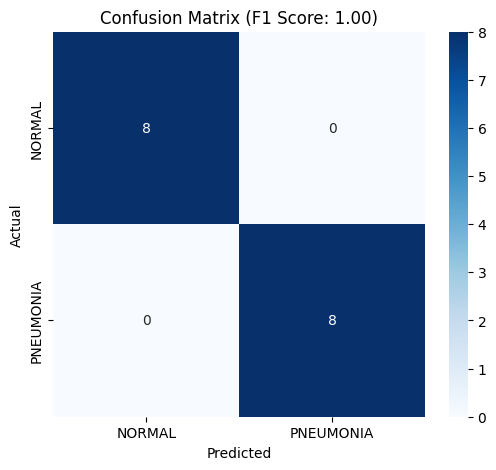

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2914162].


예측 결과: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1], 정답: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]


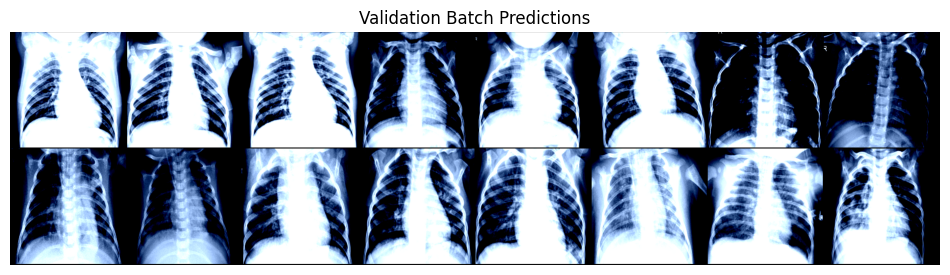


최종 검증 정확도: 100.00%


In [10]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision

# ✅ 모델 로드 및 평가 모드 설정
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# ✅ 예측 결과 저장용 리스트
y_true = []
y_pred = []

# 🔍 검증 평가
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# ✅ F1 Score 및 리포트 출력
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"\nValidation F1 Score (weighted): {f1:.2f}")

target_names = train_dataset.classes
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=target_names))

# ✅ Confusion Matrix 시각화
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title(f'Confusion Matrix (F1 Score: {f1:.2f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 🔍 예측 결과 시각화 및 정확도 계산
total_pred = 0

with torch.no_grad():
    for data, label in val_loader:
        data, label = data.to(device), label.to(device)
        pred = model(data)
        pred = torch.max(pred, 1)[1]

        total_pred += torch.sum(pred == label).item()

        print(f'예측 결과: {pred.cpu().numpy()}, 정답: {label.cpu().numpy()}')

        images_data = torchvision.utils.make_grid(data.cpu())
        plt.figure(figsize=(12, 6))
        plt.imshow(images_data.permute(1, 2, 0))
        plt.axis("off")
        plt.title("Validation Batch Predictions")
        plt.show()

# ✅ 최종 정확도 출력
val_accuracy = total_pred / len(val_loader.dataset)
print(f'\n최종 검증 정확도: {val_accuracy:.2%}')


Validation F1 Score (weighted): 1.00

Classification Report:
               precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00         8
   PNEUMONIA       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

예측 결과: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1], 정답: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2914162].


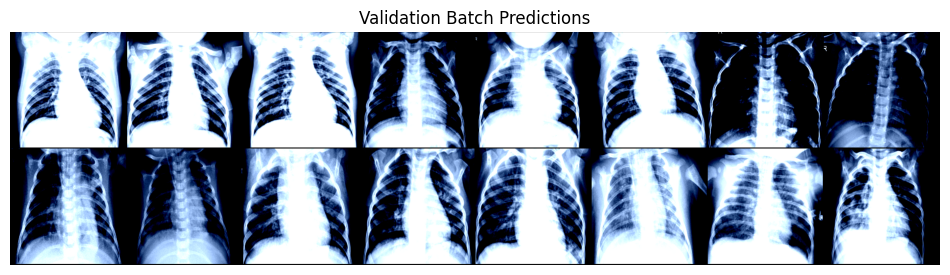


최종 검증 정확도: 100.00%


In [11]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision
import torch
import io

# ✅ SummaryWriter 초기화
writer = SummaryWriter(log_dir='runs/val_analysis')

# ✅ 모델 로드 및 평가 모드 설정
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# ✅ 예측 결과 저장용 리스트
y_true = []
y_pred = []

# 🔍 검증 평가
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# ✅ F1 Score 및 리포트 출력
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"\nValidation F1 Score (weighted): {f1:.2f}")
writer.add_scalar('F1_Score/weighted', f1)

target_names = train_dataset.classes
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=target_names))

# ✅ Confusion Matrix 시각화 및 TensorBoard 기록
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title(f'Confusion Matrix (F1 Score: {f1:.2f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 🔄 이미지 버퍼에 저장 후 TensorBoard에 기록
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
conf_matrix_img = torchvision.transforms.ToTensor()(plt.imread(buf))
writer.add_image('Confusion_Matrix', conf_matrix_img)
plt.close()

# 🔍 예측 결과 시각화 및 정확도 계산
total_pred = 0

with torch.no_grad():
    for i, (data, label) in enumerate(val_loader):
        data, label = data.to(device), label.to(device)
        pred = model(data)
        pred = torch.max(pred, 1)[1]

        total_pred += torch.sum(pred == label).item()

        print(f'예측 결과: {pred.cpu().numpy()}, 정답: {label.cpu().numpy()}')

        # ✅ 이미지 시각화 및 TensorBoard 기록
        images_data = torchvision.utils.make_grid(data.cpu())
        writer.add_image(f'Batch_{i}/Images', images_data)

        # 로컬에서도 보기 원할 경우
        plt.figure(figsize=(12, 6))
        plt.imshow(images_data.permute(1, 2, 0))
        plt.axis("off")
        plt.title("Validation Batch Predictions")
        plt.show()

# ✅ 최종 정확도 출력 및 기록
val_accuracy = total_pred / len(val_loader.dataset)
print(f'\n최종 검증 정확도: {val_accuracy:.2%}')
writer.add_scalar('Accuracy/val', val_accuracy)

# ✅ SummaryWriter 종료
writer.close()
